In [1]:
%pip install torch torchvision torchaudio
%pip install torch-geometric
%pip install matplotlib pandas scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports and Setup
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, global_mean_pool
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version: 2.8.0+cpu
CUDA available: False
Using device: cpu


In [3]:
# Load and Explore PROTEINS Dataset 
print("\n Loading PROTEINS dataset...")
dataset = TUDataset(root='/tmp/PROTEINS', name='PROTEINS')

print(f'\n{"="*60}')
print('PROTEINS Dataset Information')
print(f'{"="*60}')
print(f'Dataset: {dataset}')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of node features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'\nTask: Binary classification (enzyme vs non-enzyme proteins)')

# Explore first graph
data = dataset[0]
print(f'\nFirst graph example:')
print(f'  Number of nodes: {data.num_nodes}')
print(f'  Number of edges: {data.num_edges}')
print(f'  Node features shape: {data.x.shape}')
print(f'  Has edge features: {data.edge_attr is not None}')
print(f'  Label: {data.y.item()}')

# Class distribution
labels = [data.y.item() for data in dataset]
unique, counts = np.unique(labels, return_counts=True)
print(f'\nClass distribution:')
for label, count in zip(unique, counts):
    print(f'  Class {label}: {count} graphs ({count/len(dataset)*100:.1f}%)')


 Loading PROTEINS dataset...

PROTEINS Dataset Information
Dataset: PROTEINS(1113)
Number of graphs: 1113
Number of node features: 3
Number of classes: 2

Task: Binary classification (enzyme vs non-enzyme proteins)

First graph example:
  Number of nodes: 42
  Number of edges: 162
  Node features shape: torch.Size([42, 3])
  Has edge features: False
  Label: 0

Class distribution:
  Class 0: 663 graphs (59.6%)
  Class 1: 450 graphs (40.4%)



Statistics:
  Nodes per graph: 39.06 ± 45.76 (min: 4, max: 620)
  Edges per graph: 145.63 ± 169.20 (min: 10, max: 2098)


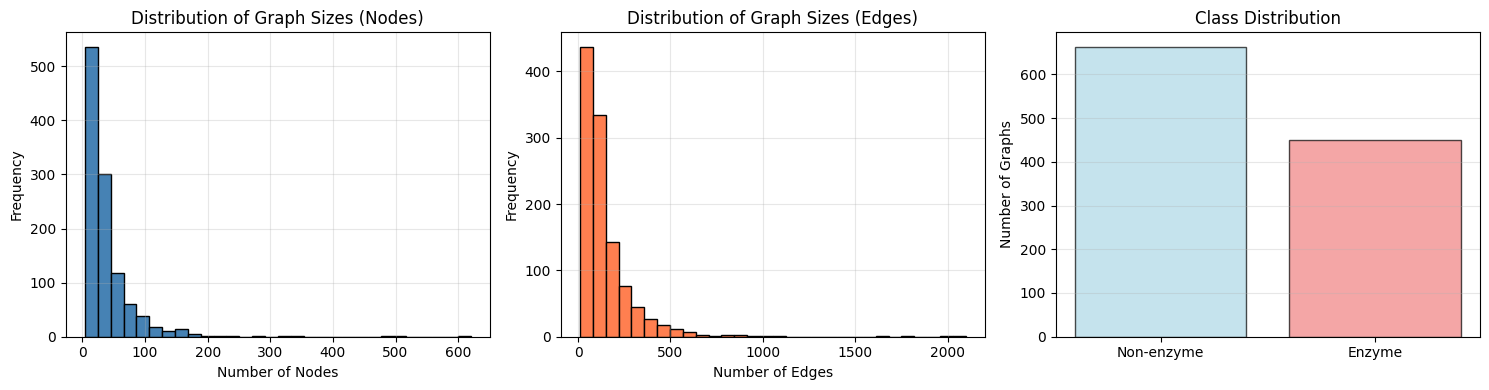

In [4]:
# Dataset Statistics
num_nodes = [data.num_nodes for data in dataset]
num_edges = [data.num_edges for data in dataset]

print(f'\nStatistics:')
print(f'  Nodes per graph: {np.mean(num_nodes):.2f} ± {np.std(num_nodes):.2f} (min: {min(num_nodes)}, max: {max(num_nodes)})')
print(f'  Edges per graph: {np.mean(num_edges):.2f} ± {np.std(num_edges):.2f} (min: {min(num_edges)}, max: {max(num_edges)})')

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Nodes distribution
axes[0].hist(num_nodes, bins=30, edgecolor='black', color='steelblue')
axes[0].set_xlabel('Number of Nodes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Graph Sizes (Nodes)')
axes[0].grid(alpha=0.3)

# Edges distribution
axes[1].hist(num_edges, bins=30, edgecolor='black', color='coral')
axes[1].set_xlabel('Number of Edges')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Graph Sizes (Edges)')
axes[1].grid(alpha=0.3)

# Class distribution
axes[2].bar(['Non-enzyme', 'Enzyme'], counts, color=['lightblue', 'lightcoral'], 
            edgecolor='black', alpha=0.7)
axes[2].set_ylabel('Number of Graphs')
axes[2].set_title('Class Distribution')
axes[2].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



In [5]:
# Train/Val/Test Split 
# Stratified split to maintain class distribution
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)
train_labels = [labels[i] for i in train_idx]
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, random_state=42, stratify=train_labels)

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f'\nDataset Split:')
print(f'  Train: {len(train_dataset)} graphs ({len(train_dataset)/len(dataset)*100:.1f}%)')
print(f'  Validation: {len(val_dataset)} graphs ({len(val_dataset)/len(dataset)*100:.1f}%)')
print(f'  Test: {len(test_dataset)} graphs ({len(test_dataset)/len(dataset)*100:.1f}%)')


Dataset Split:
  Train: 712 graphs (64.0%)
  Validation: 178 graphs (16.0%)
  Test: 223 graphs (20.0%)


In [6]:
# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        
        self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

print("GCN model defined")

GCN model defined


In [7]:
# Define GAT Model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.3)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.3)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=0.3)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

print("GAT model defined")

GAT model defined


In [8]:
# Define GraphSAGE Model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

print("GraphSAGE model defined")


GraphSAGE model defined


In [9]:

# Training and Evaluation Functions
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(loader.dataset)


@torch.no_grad()
def test(model, loader, device):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct / len(loader.dataset)


def train_model(model, model_name, train_loader, val_loader, test_loader, 
                device, epochs=200, lr=0.01, patience=30):
    """Train a model with early stopping and return training history"""
    print(f'\n{"="*70}')
    print(f'Training {model_name} on PROTEINS Dataset')
    print(f'{"="*70}')
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    
    history = defaultdict(list)
    best_val_acc = 0
    best_test_acc = 0
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, criterion, device)
        train_acc = test(model, train_loader, device)
        val_acc = test(model, val_loader, device)
        test_acc = test(model, test_loader, device)
        
        history['loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['test_acc'].append(test_acc)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                  f'Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    print(f'\n{model_name} Results:')
    print(f'  Best Val Acc: {best_val_acc:.4f} (at epoch {best_epoch})')
    print(f'  Test Acc (at best val): {best_test_acc:.4f}')
    
    return best_val_acc, best_test_acc, history

print("Training functions defined")


Training functions defined


In [10]:
# Train GCN 
print("\n Starting GCN training...")
gcn_model = GCN(dataset.num_features, 128, dataset.num_classes, num_layers=3)
gcn_val, gcn_test, gcn_history = train_model(
    gcn_model, 'GCN', train_loader, val_loader, test_loader, device
)



 Starting GCN training...

Training GCN on PROTEINS Dataset


C:\Users\Suhana Shaik\AppData\Local\Temp\ipykernel_15916\3241382747.py:12: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  total_loss += float(loss) * data.num_graphs


Epoch: 010, Loss: 0.6226, Train: 0.6475, Val: 0.6236, Test: 0.5874
Epoch: 020, Loss: 0.6370, Train: 0.6798, Val: 0.6798, Test: 0.6323
Epoch: 030, Loss: 0.6225, Train: 0.7107, Val: 0.7022, Test: 0.6861
Epoch: 040, Loss: 0.6082, Train: 0.7051, Val: 0.6854, Test: 0.6771
Epoch: 050, Loss: 0.6202, Train: 0.7275, Val: 0.7191, Test: 0.7220
Epoch: 060, Loss: 0.6144, Train: 0.7008, Val: 0.7191, Test: 0.6637
Early stopping at epoch 69

GCN Results:
  Best Val Acc: 0.7360 (at epoch 39)
  Test Acc (at best val): 0.6726


In [11]:
# Train GAT
print("\n Starting GAT training...")
gat_model = GAT(dataset.num_features, 128, dataset.num_classes, heads=4)
gat_val, gat_test, gat_history = train_model(
    gat_model, 'GAT', train_loader, val_loader, test_loader, device
)



 Starting GAT training...

Training GAT on PROTEINS Dataset
Epoch: 010, Loss: 0.6531, Train: 0.6685, Val: 0.6517, Test: 0.6457
Epoch: 020, Loss: 0.6281, Train: 0.6840, Val: 0.6966, Test: 0.6323
Epoch: 030, Loss: 0.6073, Train: 0.6994, Val: 0.7022, Test: 0.6637
Epoch: 040, Loss: 0.6056, Train: 0.6966, Val: 0.7022, Test: 0.6771
Epoch: 050, Loss: 0.5977, Train: 0.6994, Val: 0.7022, Test: 0.6996
Epoch: 060, Loss: 0.6067, Train: 0.7163, Val: 0.7022, Test: 0.6996
Early stopping at epoch 66

GAT Results:
  Best Val Acc: 0.7247 (at epoch 36)
  Test Acc (at best val): 0.6547


In [12]:
# Train GraphSAGE
print("\n Starting GraphSAGE training...")
sage_model = GraphSAGE(dataset.num_features, 128, dataset.num_classes)
sage_val, sage_test, sage_history = train_model(
    sage_model, 'GraphSAGE', train_loader, val_loader, test_loader, device
)



 Starting GraphSAGE training...

Training GraphSAGE on PROTEINS Dataset
Epoch: 010, Loss: 0.6208, Train: 0.7149, Val: 0.7079, Test: 0.7130
Epoch: 020, Loss: 0.6099, Train: 0.6657, Val: 0.6966, Test: 0.6323
Epoch: 030, Loss: 0.6015, Train: 0.6924, Val: 0.6966, Test: 0.6637
Epoch: 040, Loss: 0.6041, Train: 0.6882, Val: 0.6910, Test: 0.6457
Epoch: 050, Loss: 0.5972, Train: 0.7135, Val: 0.7191, Test: 0.6726
Early stopping at epoch 57

GraphSAGE Results:
  Best Val Acc: 0.7303 (at epoch 27)
  Test Acc (at best val): 0.6413


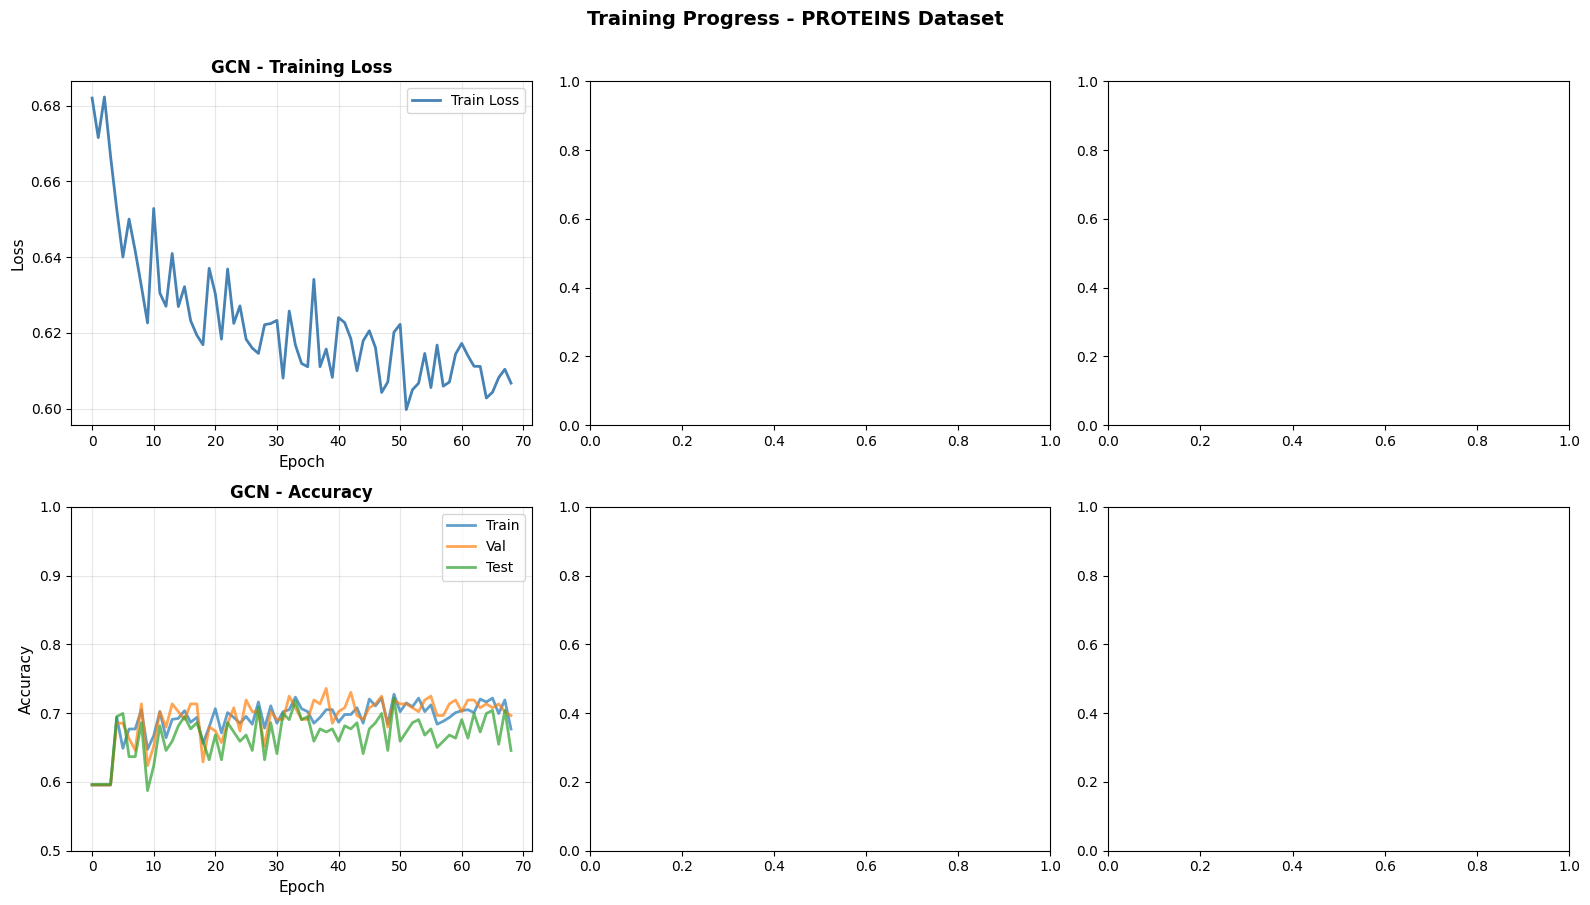

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot Training Curves
fig, axes = plt.subplots(2, 3, figsize=(16, 9))

models = [('GCN', gcn_history), ('GAT', gat_history), ('GraphSAGE', sage_history)]
colors = ['steelblue', 'coral', 'mediumseagreen']

for idx, (name, history) in enumerate(models):
    # Loss curve
    axes[0, idx].plot(history['loss'], label='Train Loss', linewidth=2, color=colors[idx])
    axes[0, idx].set_xlabel('Epoch', fontsize=11)
    axes[0, idx].set_ylabel('Loss', fontsize=11)
    axes[0, idx].set_title(f'{name} - Training Loss', fontsize=12, fontweight='bold')
    axes[0, idx].grid(alpha=0.3)
    axes[0, idx].legend()
        
    # Accuracy curves
    axes[1, idx].plot(history['train_acc'], label='Train', linewidth=2, alpha=0.7)
    axes[1, idx].plot(history['val_acc'], label='Val', linewidth=2, alpha=0.7)
    axes[1, idx].plot(history['test_acc'], label='Test', linewidth=2, alpha=0.7)
    axes[1, idx].set_xlabel('Epoch', fontsize=11)
    axes[1, idx].set_ylabel('Accuracy', fontsize=11)
    axes[1, idx].set_title(f'{name} - Accuracy', fontsize=12, fontweight='bold')
    axes[1, idx].grid(alpha=0.3)
    axes[1, idx].legend()
    axes[1, idx].set_ylim([0.5, 1.0])

    plt.suptitle('Training Progress - PROTEINS Dataset', fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

In [17]:
# Final Comparison
results = {
    'GCN': {'val': gcn_val, 'test': gcn_test},
    'GAT': {'val': gat_val, 'test': gat_test},
    'GraphSAGE': {'val': sage_val, 'test': sage_test}
}

print(f'\n{"="*70}')
print('FINAL RESULTS - Graph Classification on PROTEINS Dataset')
print(f'{"="*70}')
print(f'{"Model":<15} {"Val Accuracy":<20} {"Test Accuracy":<20}')
print(f'{"-"*70}')
for model_name, acc in results.items():
    print(f'{model_name:<15} {acc["val"]:.4f} ({acc["val"]*100:.2f}%)     {acc["test"]:.4f} ({acc["test"]*100:.2f}%)')

best_model = max(results.items(), key=lambda x: x[1]['test'])
print(f'\n Best Model: {best_model[0]} with Test Accuracy: {best_model[1]["test"]:.4f} ({best_model[1]["test"]*100:.2f}%)')
print(f'{"="*70}')



FINAL RESULTS - Graph Classification on PROTEINS Dataset
Model           Val Accuracy         Test Accuracy       
----------------------------------------------------------------------
GCN             0.7360 (73.60%)     0.6726 (67.26%)
GAT             0.7247 (72.47%)     0.6547 (65.47%)
GraphSAGE       0.7303 (73.03%)     0.6413 (64.13%)

 Best Model: GCN with Test Accuracy: 0.6726 (67.26%)


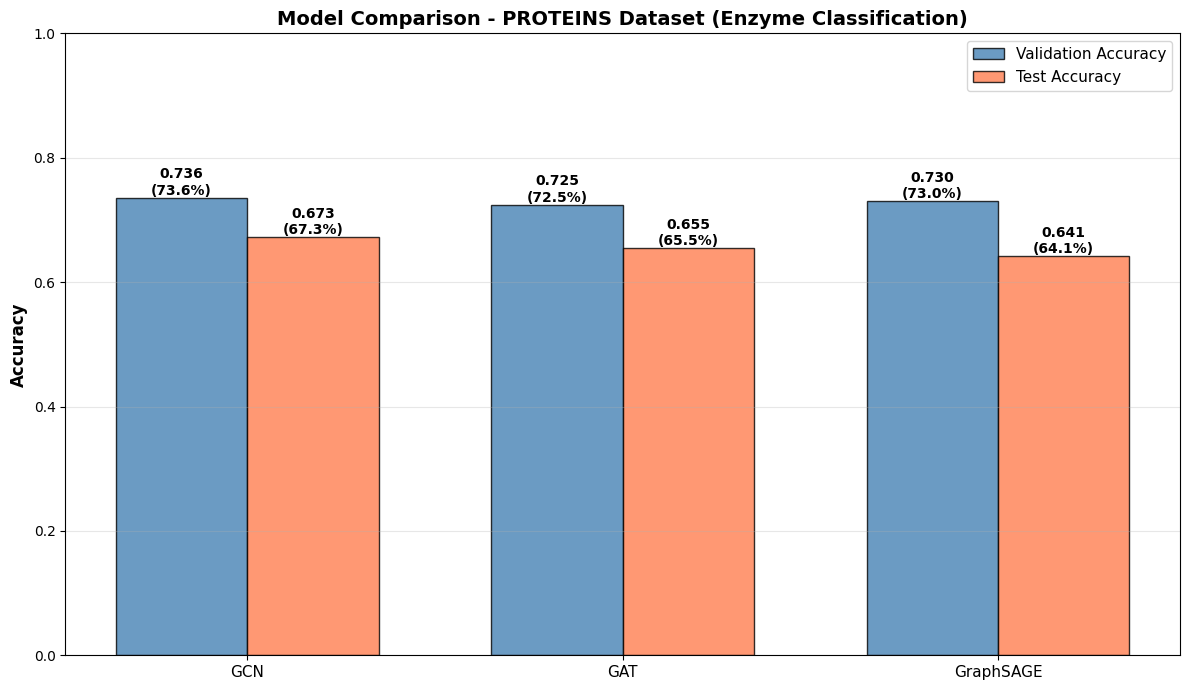

In [15]:
# Bar Plot Comparison

fig, ax = plt.subplots(figsize=(12, 7))

models_list = list(results.keys())
val_accs = [results[m]['val'] for m in models_list]
test_accs = [results[m]['test'] for m in models_list]

x = np.arange(len(models_list))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Accuracy', 
                alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy', 
                alpha=0.8, color='coral', edgecolor='black')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison - PROTEINS Dataset (Enzyme Classification)', 
                fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_list, fontsize=11)
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')
ax.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}\n({height*100:.1f}%)', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:

print(f"\n Experiment completed on PROTEINS dataset!")
print(f"   Dataset: Protein graphs (enzymes vs non-enzymes)")
print(f"   Total graphs: {len(dataset)}")
print(f"   Best performing model: {best_model[0]} ({best_model[1]['test']*100:.2f}% test accuracy)")


 Experiment completed on PROTEINS dataset!
   Dataset: Protein graphs (enzymes vs non-enzymes)
   Total graphs: 1113
   Best performing model: GCN (67.26% test accuracy)
